# Data Quality Projet
## Alzoubaidy Maxime | Babikian Mathieu | Guibert Ulysse 
### DataSet : 
Le jeu de données "The Metropolitan Museum of Art Open Access" survole 5 000 ans d'histoire, il contient des oeuvres d'art de toutes les périodes et de toutes les cultures de la civilisation humaine. Ce jeu de données est constitué de presque 485 000 lignes d'oeuvres d'art, détaillées par des dizaines de colonnes. C'est un excellent support pour l'exercice de la Data Quality et des tâches de Machine Learning. 
https://github.com/metmuseum/openaccess/
### Objectifs : Clusters & Prédiction 
Le jeu de données peut être utilisées pour explorer des groupes thématiques d'objets, afin de ***classer les objets selon des thèmes comme les matériaux***, les styles, les techniques ou les mouvements artistiques particuliers.
Il peut aussi être utilisé pour prédire la ***pertinence des objets pour les musées***.

#### Imports

In [110]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
# from imblearn.over_sampling import SMOTE


import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

#### Etape 1 : Séparation en données numérique et non numérique

In [111]:
# read the data
df = pd.read_csv('MetObjects.csv', delimiter=",")

# shape and data types of the data
print(df.shape)
print(df.dtypes)
# select numeric columns
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)

# select non numeric columns
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print(non_numeric_cols)

C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_15256\3235935865.py:2: DtypeWarning: Columns (5,7,10,11,12,13,14,34,35,36,37,38,39,40,41,42,43,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('MetObjects.csv', delimiter=",")


(484956, 54)
Object Number               object
Is Highlight                  bool
Is Timeline Work              bool
Is Public Domain              bool
Object ID                    int64
Gallery Number              object
Department                  object
AccessionYear               object
Object Name                 object
Title                       object
Culture                     object
Period                      object
Dynasty                     object
Reign                       object
Portfolio                   object
Constituent ID              object
Artist Role                 object
Artist Prefix               object
Artist Display Name         object
Artist Display Bio          object
Artist Suffix               object
Artist Alpha Sort           object
Artist Nationality          object
Artist Begin Date           object
Artist End Date             object
Artist Gender               object
Artist ULAN URL             object
Artist Wikidata URL         object
Object 

In [112]:
df_numeric.head()

,Object ID,Object Begin Date,Object End Date,Metadata Date
0,1,1853,1853,NaN
1,2,1901,1901,NaN
2,3,1909,1927,NaN
3,4,1909,1927,NaN
4,5,1909,1927,NaN


In [113]:
df_non_numeric.head()

,Object Number,Is Highlight,Is Timeline Work,Is Public Domain,Gallery Number,Department,AccessionYear,Object Name,Title,Culture,...,Excavation,River,Classification,Rights and Reproduction,Link Resource,Object Wikidata URL,Repository,Tags,Tags AAT URL,Tags Wikidata URL
0,1979.486.1,False,False,False,NaN,The American Wing,1979.0,Coin,One-dollar Liberty Head Coin,NaN,...,NaN,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/1,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
1,1980.264.5,False,False,False,NaN,The American Wing,1980.0,Coin,Ten-dollar Liberty Head Coin,NaN,...,NaN,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/2,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
2,67.265.9,False,False,False,NaN,The American Wing,1967.0,Coin,Two-and-a-Half Dollar Coin,NaN,...,NaN,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/3,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
3,67.265.10,False,False,False,NaN,The American Wing,1967.0,Coin,Two-and-a-Half Dollar Coin,NaN,...,NaN,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/4,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
4,67.265.11,False,False,False,NaN,The American Wing,1967.0,Coin,Two-and-a-Half Dollar Coin,NaN,...,NaN,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/5,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN


#### Etape 2 : Détection des données manquantes

A / Visualisation 2D des données manquantes

<Axes: >

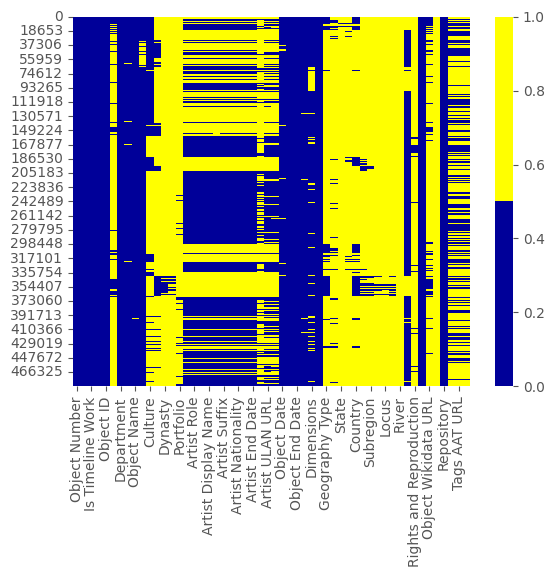

In [114]:
cols = df.columns[:]
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

Les données manquantes sont mises en évidence en jaune, tandis que les données présentes sont représentées en bleu. Cette visualisation met en lumière un grand nombre de valeurs nulles. Cela indique qu’un traitement approfondi des données sera nécessaire pour garantir leur qualité et leur exploitation optimale.



B / Pourcentage de données manquantes 

In [115]:
columns_with_missing = []

# Étape 1 : Afficher le pourcentage de valeurs manquantes pour toutes les colonnes
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing * 100)))
    if pct_missing >= 0.5:
        columns_with_missing.append(col)

# Étape 2 : Calculer et afficher les totaux >50% et <50%
total_more_than_50 = len(columns_with_missing)
total_less_than_50 = len(df.columns) - total_more_than_50

print("--------------------------------------")
print(f"Colonnes avec au moins 50% de valeurs manquantes: {total_more_than_50}")
print(f"Colonnes avec moins de 50% de valeurs manquantes: {total_less_than_50}")


Object Number - 0%
Is Highlight - 0%
Is Timeline Work - 0%
Is Public Domain - 0%
Object ID - 0%
Gallery Number - 90%
Department - 0%
AccessionYear - 1%
Object Name - 0%
Title - 6%
Culture - 57%
Period - 81%
Dynasty - 95%
Reign - 98%
Portfolio - 95%
Constituent ID - 42%
Artist Role - 42%
Artist Prefix - 42%
Artist Display Name - 42%
Artist Display Bio - 42%
Artist Suffix - 42%
Artist Alpha Sort - 42%
Artist Nationality - 42%
Artist Begin Date - 42%
Artist End Date - 42%
Artist Gender - 78%
Artist ULAN URL - 53%
Artist Wikidata URL - 54%
Object Date - 3%
Object Begin Date - 0%
Object End Date - 0%
Medium - 1%
Dimensions - 15%
Credit Line - 0%
Geography Type - 88%
City - 93%
State - 99%
County - 98%
Country - 84%
Region - 94%
Subregion - 95%
Locale - 97%
Locus - 98%
Excavation - 97%
River - 100%
Classification - 16%
Rights and Reproduction - 95%
Link Resource - 0%
Object Wikidata URL - 86%
Metadata Date - 100%
Repository - 0%
Tags - 60%
Tags AAT URL - 60%
Tags Wikidata URL - 60%
---------

Face au manque de clarté initial, nous avons décidé d’écrire nos valeurs dans un fichier pour faciliter l’analyse. Dans un premier temps, nous avions envisagé un clustering basé sur les lieux (en utilisant les colonnes country, region, etc.). Cependant, nous avons constaté que plus de 95 % des valeurs de ces colonnes étaient nulles, rendant cette approche impraticable.
Par la suite, nous avons retenu deux nouvelles idées : un clustering basé sur les artistes et un autre basé sur les matériaux et les méthodes.

In [116]:

df_info = pd.DataFrame({
    'Nom de la colonne': df.columns,
    'Type de la colonne': df.dtypes,
    'Pourcentage de valeurs manquantes': [round(np.mean(df[col].isnull()) * 100, 2) for col in df.columns]
})
df_info.to_csv("TypeColonne.csv",sep=",",index=False,encoding="utf-8")

C / Detecter et supprimer les lignes et colonne avec beaucoup de données manquante

In [117]:
# Drop rows where "Artist Display Bio" is empty, since all the rows with this value missing are non relevant
df = df[df['Artist Display Bio'].notnull()]

# Supprimer les lignes avec plus de 60% de valeurs manquantes
threshold_row = 0.6  # Seuil de 60%
df = df.loc[df.isnull().mean(axis=1) <= threshold_row]

# Supprimer les colonnes avec plus de 50% de valeurs manquantes
threshold_col = 0.50  # Seuil de 50% obtenu manuellement, permettant de retirer les colonnes non significatives. (60% pour garder les tags)
df = df.loc[:, df.isnull().mean() <= threshold_col]

# Enlever les colonnes contenant des URL

Nous commençons par nettoyer le dataset. Pour cela, nous supprimons les lignes comportant plus de 60 % de valeurs manquantes, ainsi que les colonnes présentant au moins 50 % de valeurs manquantes. Ces seuils ont été définis de manière arbitraire, car ils nous semblaient raisonnables pour cette analyse.

In [118]:
df.shape

(280423, 30)

D / Indicateur de donnée manquante

Created missing indicator for: AccessionYear
Created missing indicator for: Object Name
Created missing indicator for: Title
Created missing indicator for: Artist Suffix
Created missing indicator for: Artist ULAN URL
Created missing indicator for: Artist Wikidata URL
Created missing indicator for: Object Date
Created missing indicator for: Medium
Created missing indicator for: Dimensions
Created missing indicator for: Credit Line
Created missing indicator for: Classification
0         1
1         1
9         1
10        1
11        1
         ..
484951    2
484952    2
484953    2
484954    5
484955    2
Name: num_missing, Length: 280423, dtype: int64
num_missing
0    177191
2     59910
1     30725
3      6526
4      5683
5       246
7        72
6        69
8         1
Name: count, dtype: int64


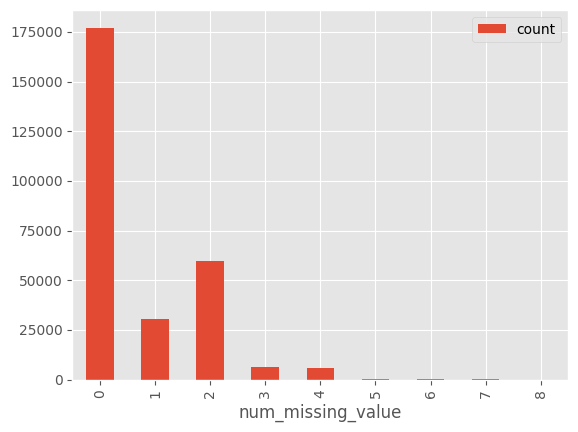

In [119]:
for col in df.columns:
    missing = df[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  
        print(f'Created missing indicator for: {col}')
        df[f'{col}_ismissing'] = missing


ismissing_cols = [col for col in df.columns if 'missing' in col]
df['num_missing'] = df[ismissing_cols].sum(axis=1)

print(df['num_missing'])
print(df['num_missing'].value_counts())


value_counts_df = df['num_missing'].value_counts().reset_index()
value_counts_df.columns = ['num_missing_value', 'count']  # Renommer les colonnes après 
value_counts_df.sort_values(by='num_missing_value').plot.bar(x='num_missing_value', y='count')


# Drop the 'ismissing' columns
df.drop(columns=ismissing_cols, inplace=True)

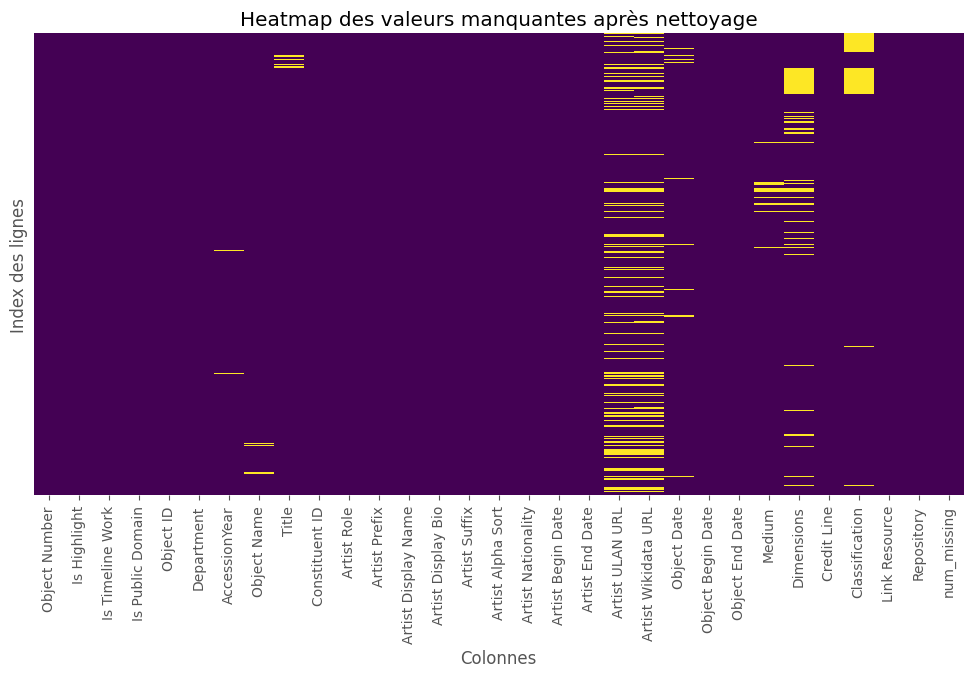

In [120]:
# Générer une heatmap des valeurs manquantes
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis", yticklabels=False)
plt.title("Heatmap des valeurs manquantes après nettoyage")
plt.xlabel("Colonnes")
plt.ylabel("Index des lignes")
plt.show()

In [121]:
df_info = pd.DataFrame({
    'Column Name': df.columns,
    'Column Type': df.dtypes.values
})

# Exporter vers un fichier CSV
df_info.to_csv('columns_info.csv', index=False, encoding='utf-8')

print("Fichier 'columns_info.csv' créé avec succès.")

Fichier 'columns_info.csv' créé avec succès.


E / Doublon de ligne et de l'id.

In [122]:
print("Nombre ligne dupliquée :", df.duplicated().sum())

Nombre ligne dupliquée : 0


In [123]:
print("Nombre ligne dupliquée :", df["Object Number"].duplicated().sum())

Nombre ligne dupliquée : 1126


In [124]:
df = df.drop_duplicates(subset='Object Number', keep='first')
print("Nombre ligne dupliquée :", df["Object Number"].duplicated().sum())

Nombre ligne dupliquée : 0


F / Données Inconsistantes 

In [125]:
df["Medium"] = df["Medium"].str.lower()
df["Classification"] = df["Classification"].str.lower()


In [126]:
df['Medium'].value_counts(dropna=False)

Medium
commercial color lithograph                                                                                                                                                               18917
etching                                                                                                                                                                                   17392
engraving                                                                                                                                                                                 11696
gelatin silver print                                                                                                                                                                      10286
albumen photograph                                                                                                                                                                         9681
                                 

In [127]:
# Afficher les valeurs de 'Medium' qui apparaissent moins de 5 fois
counts = df['Medium'].value_counts(dropna=False)
values_less_than_5 = counts[counts < 3]

print(values_less_than_5)


Medium
pine veneered with mahogany; gilt bronze                                                                                                                                                  2
pen and carbon black ink, brush and wash, over graphite                                                                                                                                   2
soft-paste porcelain, copper gilt                                                                                                                                                         2
black chalk, stumped, highlighted with white, on gray-green paper                                                                                                                         2
drypoint and monotype                                                                                                                                                                     2
                                                     

In [128]:
df['Classification'].value_counts(dropna=False)

Classification
prints                                                                 82689
NaN                                                                    29880
photographs                                                            27196
prints|ephemera                                                        24789
drawings                                                               22830
                                                                       ...  
woodwork-furniture|chordophone-zither-plucked-harpsichord|paintings        1
archery equipment                                                          1
metalwork-silver|metalwork-steel|knives                                    1
metalwork|lighting                                                         1
mail                                                                       1
Name: count, Length: 764, dtype: int64

In [129]:
# Afficher les valeurs de 'Classification' qui apparaissent moins de 5 fois
counts = df['Classification'].value_counts(dropna=False)
values_less_than_5 = counts[counts < 3]

print(values_less_than_5)


Classification
horology|metalwork-gilt bronze                                         2
equestrian equipment-bits                                              2
miscellaneous-ironwork                                                 2
metalwork-silver in combination|paintings                              2
stone-vessels                                                          2
                                                                      ..
woodwork-furniture|chordophone-zither-plucked-harpsichord|paintings    1
archery equipment                                                      1
metalwork-silver|metalwork-steel|knives                                1
metalwork|lighting                                                     1
mail                                                                   1
Name: count, Length: 340, dtype: int64


In [130]:
df.shape

(279297, 31)

In [131]:
# Compter les occurrences des valeurs dans la colonne 'Classification'
counts = df['Classification'].value_counts(dropna=False)

# Identifier les valeurs qui apparaissent moins de 5 fois
values_less_than_5 = counts[counts < 5].index

# Supprimer les lignes où 'Classification' contient ces valeurs
df = df[~df['Classification'].isin(values_less_than_5)]


In [132]:
# Compter les occurrences des valeurs dans la colonne 'Medium'
counts = df['Medium'].value_counts(dropna=False)

# Identifier les valeurs qui apparaissent moins de 5 fois
values_less_than_5 = counts[counts < 5].index

# Supprimer les lignes où 'Classification' contient ces valeurs
df = df[~df['Medium'].isin(values_less_than_5)]



In [133]:
df.shape

(236341, 31)

In [134]:
df['Artist Nationality'].value_counts(dropna=False)

Artist Nationality
American                                                                                                                 61263
                                                                                                                         21161
French                                                                                                                   16857
British                                                                                                                  10211
Italian                                                                                                                   9565
                                                                                                                         ...  
British|British|British|German|British                                                                                       1
British|British|British|British|British|British|Irish|British, born Italy                   

#### Etape 3 : Normalisation des données

In [135]:
# Nettoyage de la colonne 'Artist Nationality'
df['Artist Nationality'] = df['Artist Nationality'].str.split(r'\W+').str[0]

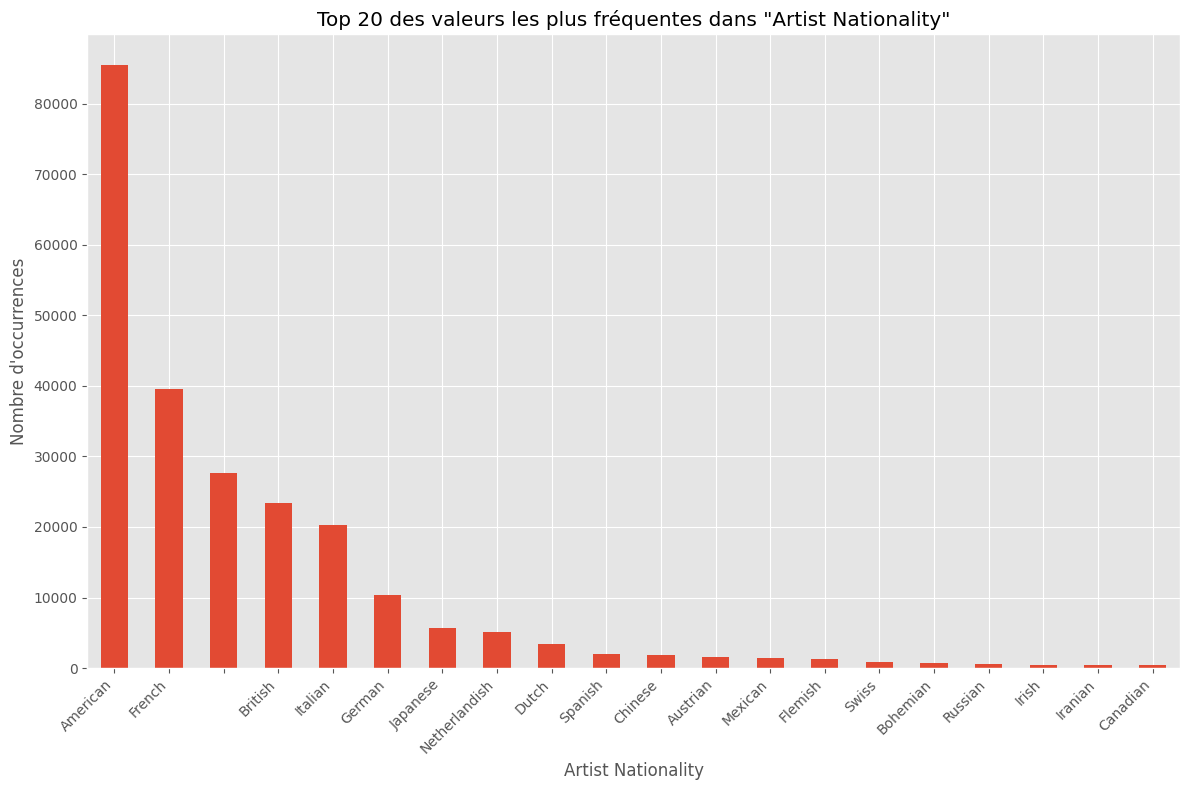

(161, 232493)

In [136]:
# Compter les occurrences des valeurs dans la colonne "Artist Nationality"
classification_counts = df['Artist Nationality'].value_counts()

# Total des valeurs uniques dans la colonne "Classification"
total_unique_values = classification_counts.shape[0]

# Sélection des 20 valeurs les plus fréquentes
top_20_values = classification_counts.head(20)

# Création de l'histogramme
plt.figure(figsize=(12, 8))
top_20_values.plot(kind='bar')
plt.title('Top 20 des valeurs les plus fréquentes dans "Artist Nationality"')
plt.xlabel('Artist Nationality')
plt.ylabel('Nombre d\'occurrences')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Affichage des résultats
total_unique_values, top_20_values.sum()

In [137]:
# 1. Convertir le contenu de la colonne "Artist Role" en minuscules
df["Artist Role"] = df["Artist Role"].str.lower()

# 2. Dans une nouvelle colonne, remplacer " and " par "|" pour traiter les individus à plusieurs roles
df["Artist Role Uni"] = df["Artist Role"].str.replace(r'\b and \b', '|', regex=True)

# 3. Extraire tous les rôles uniques
unique_roles = set(
    role.strip() 
    for roles in df["Artist Role Uni"] 
    for role in roles.split('|')
)

# 4. Pour chaque rôle unique, créer une colonne avec le nombre d'occurrences
for role in unique_roles:
    df[role] = df["Artist Role Uni"].apply(lambda x: x.split('|').count(role))

df.drop(columns=["Artist Role Uni"], inplace=True)

In [138]:
columns_to_check = [
    "Artist Prefix",
    "Artist Display Name",
    "Artist Display Bio",
    "Artist Suffix",
    "Artist Alpha Sort",
    "Artist Nationality",
    "Artist Begin Date",
    "Artist End Date",
    #"Artist Gender",
    "Artist ULAN URL",
    "Artist Wikidata URL"
]

# Fonction pour compter les séparateurs "|" dans une chaîne
def count_pipes(value):
    if pd.isna(value):  # Si la valeur est NaN, elle est considérée comme ayant zéro "|"
        return 0
    return value.count('|')

# Vérifier que chaque colonne a le même nombre de "|" que "Artist Role" et donc que l'individu associé au role ait bien tout ses informations présentes
def verify_pipes(row):
    artist_role_pipes = count_pipes(row["Artist Role"])
    for column in columns_to_check:
        if count_pipes(row[column]) != artist_role_pipes:
            return False
    return True

# Ajouter la colonne "Artist Verification"
df["Artist Verification"] = df.apply(verify_pipes, axis=1)

# Afficher le nombre de True et False dans la colonne "Artist Verification"
verification_counts = df["Artist Verification"].value_counts()
print("\nNumber of True and False values in 'Artist Verification':")
print(verification_counts)

df.drop(columns=["Artist Verification"], inplace=True)


Number of True and False values in 'Artist Verification':
Artist Verification
True     151666
False     84675
Name: count, dtype: int64


In [139]:
unique_roles

{'architect',
 'armorer',
 'artist',
 'author',
 'barrelsmith',
 'binder',
 'bladesmith',
 'block cutter',
 'calligrapher',
 'collaborator',
 'collector',
 'correspondent',
 'couture line',
 'culture',
 'decorator',
 'dedicatee',
 'department store',
 'design house',
 'designer',
 'draftsman',
 'editor',
 'enameler',
 'engraver',
 'etcher',
 'factory',
 'factory director',
 'factory owner',
 'fittings maker',
 'former attribution',
 'founder',
 'goldsmith',
 'gunsmith',
 'hilt maker',
 'illuminator',
 'illustrator',
 'inlayer',
 'inscriber',
 'inventor',
 'lithographer',
 'lock maker',
 'maker',
 'manufactory',
 'manufacturer',
 'modeler',
 'mount maker',
 'papermaker',
 'patentee',
 'patron',
 'person in photograph',
 'photo source',
 'photographer',
 'photography studio',
 'poet',
 'printer',
 'printmaker',
 'publisher',
 'purveyor',
 'retailer',
 'secondary line',
 'silversmith',
 'sitter',
 'source',
 'steel-chiseler',
 'subject',
 'subject of book',
 'swordsmith',
 'translator',
 

In [140]:
df.to_csv('MetObjects_cleaned.csv', index=False)

In [141]:
df_info = pd.DataFrame({
    'Column Name': df.columns,
    'Column Type': df.dtypes.values
})

# Exporter vers un fichier CSV
df_info.to_csv('columns_info.csv', index=False, encoding='utf-8')

print("Fichier 'columns_info.csv' créé avec succès.")

Fichier 'columns_info.csv' créé avec succès.


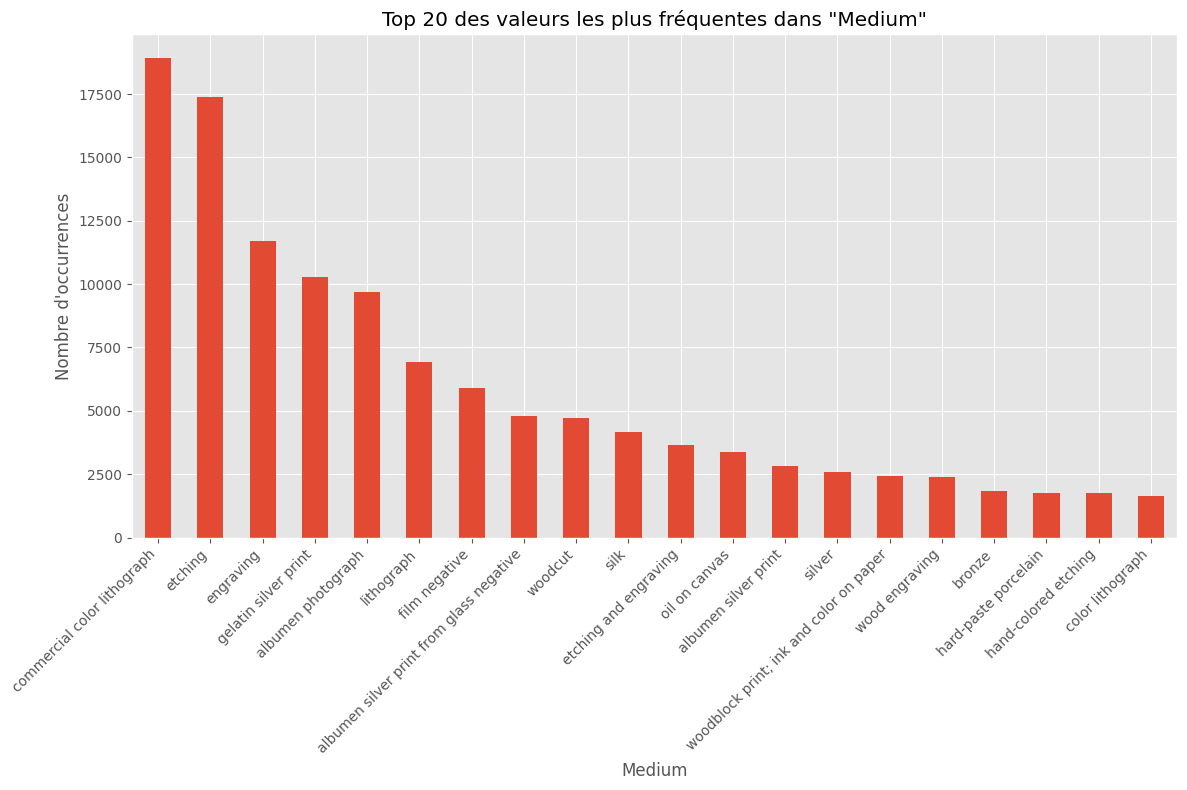

(2896, 118715)

In [142]:
# Compter les occurrences des valeurs dans la colonne "Artist Nationality"
classification_counts = df['Medium'].value_counts()

# Total des valeurs uniques dans la colonne "Classification"
total_unique_values = classification_counts.shape[0]

# Sélection des 20 valeurs les plus fréquentes
top_20_values = classification_counts.head(20)

# Création de l'histogramme
plt.figure(figsize=(12, 8))
top_20_values.plot(kind='bar')
plt.title('Top 20 des valeurs les plus fréquentes dans "Medium"')
plt.xlabel('Medium')
plt.ylabel('Nombre d\'occurrences')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Affichage des résultats
total_unique_values, top_20_values.sum()

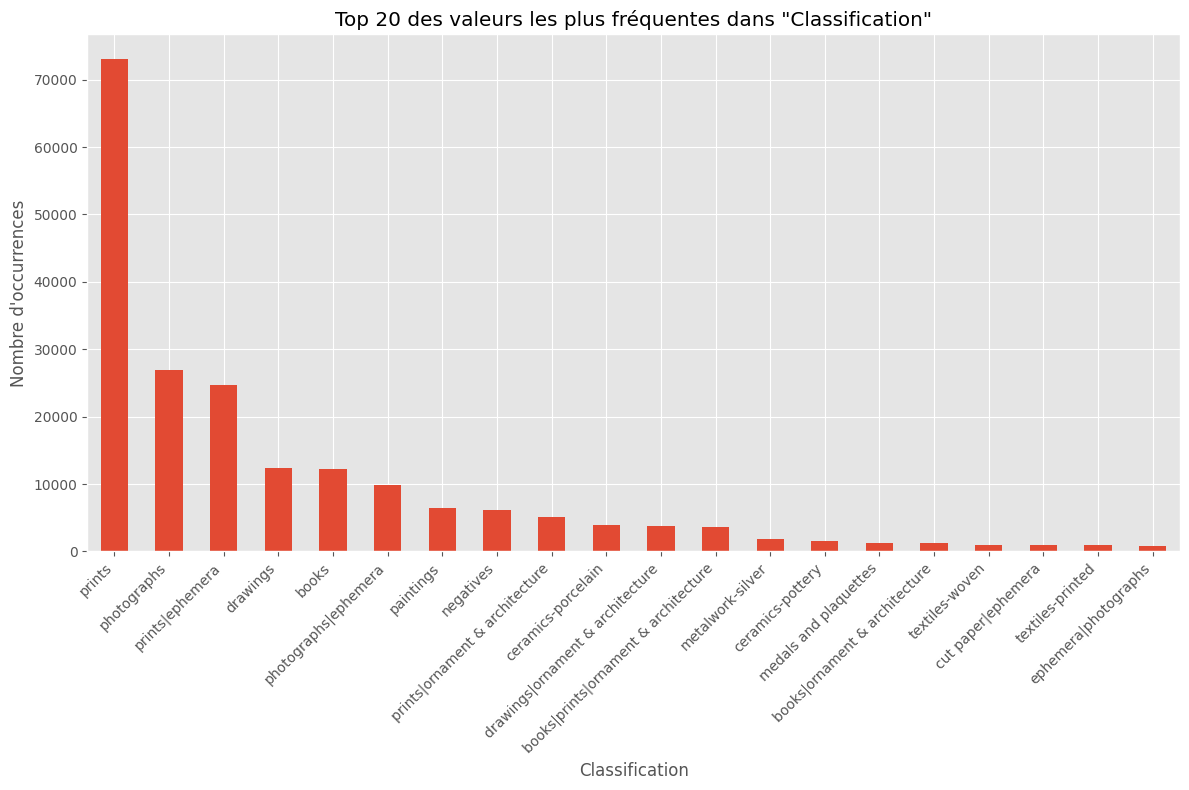

(314, 197867)

In [143]:
# Compter les occurrences des valeurs dans la colonne "Artist Nationality"
classification_counts = df['Classification'].value_counts()

# Total des valeurs uniques dans la colonne "Classification"
total_unique_values = classification_counts.shape[0]

# Sélection des 20 valeurs les plus fréquentes
top_20_values = classification_counts.head(20)

# Création de l'histogramme
plt.figure(figsize=(12, 8))
top_20_values.plot(kind='bar')
plt.title('Top 20 des valeurs les plus fréquentes dans "Classification"')
plt.xlabel('Classification')
plt.ylabel('Nombre d\'occurrences')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Affichage des résultats
total_unique_values, top_20_values.sum()

Nous constatons ici une forte présence de "prints" et de "photographs". Ces catégories, souvent perçues comme moins adaptées à une exposition permanente dans un musée, pourraient trouver leur place dans des galeries éphémères, où leur valeur et leur impact pourraient être mis en avant de manière contextuelle et temporaire. Quant aux autres œuvres, elles semblent plus adaptées pour enrichir les collections permanentes et les différentes galeries de notre musée.

**Objectif :**
Entraîner un modèle capable de déterminer quels objets seront intéressants à mettre en avant dans le musée. 

In [144]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Charger le dataset
df = pd.read_csv("MetObjects_cleaned.csv")  # Remplacez par le chemin réel
df.head()  # Aperçu des premières lignes

C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_15256\3870441249.py:11: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("MetObjects_cleaned.csv")  # Remplacez par le chemin réel


,Object Number,Is Highlight,Is Timeline Work,Is Public Domain,Object ID,Department,AccessionYear,Object Name,Title,Constituent ID,...,mount maker,factory director,illuminator,editor,inventor,fittings maker,modeler,sitter,goldsmith,former attribution
0,1979.486.1,False,False,False,1,The American Wing,1979.0,Coin,One-dollar Liberty Head Coin,16429,...,0,0,0,0,0,0,0,0,0,0
1,1980.264.5,False,False,False,2,The American Wing,1980.0,Coin,Ten-dollar Liberty Head Coin,107,...,0,0,0,0,0,0,0,0,0,0
2,1979.486.3,False,False,False,10,The American Wing,1979.0,Coin,Two-and-a-half-dollar Indian Head Coin,108,...,0,0,0,0,0,0,0,0,0,0
3,1979.486.2,False,False,False,11,The American Wing,1979.0,Coin,Two-and-a-half-dollar Liberty Head Coin,107,...,0,0,0,0,0,0,0,0,0,0
4,1979.486.7,False,False,False,12,The American Wing,1979.0,Coin,Twenty-dollar Liberty Head Coin,16429,...,0,0,0,0,0,0,0,0,0,0


In [145]:
df.columns

Index(['Object Number', 'Is Highlight', 'Is Timeline Work', 'Is Public Domain',
       'Object ID', 'Department', 'AccessionYear', 'Object Name', 'Title',
       'Constituent ID',
       ...
       'mount maker', 'factory director', 'illuminator', 'editor', 'inventor',
       'fittings maker', 'modeler', 'sitter', 'goldsmith',
       'former attribution'],
      dtype='object', length=101)

In [146]:
# Garder uniquement les colonnes "Medium" et "Classification"
selected_columns = ["Medium", "Classification"]

# Filtrer les colonnes présentes et retirer les lignes où tout est manquant
df_materials = df[selected_columns].dropna(how="all")
df_materials.head()


,Medium,Classification
0,gold,NaN
1,gold,NaN
2,gold,NaN
3,gold,NaN
4,gold,NaN


In [147]:
# Remplacer les valeurs manquantes par "Unknown"
imputer = SimpleImputer(strategy="constant", fill_value="Unknown")
df_materials_imputed = pd.DataFrame(imputer.fit_transform(df_materials), columns=selected_columns)
df_materials_imputed.head()

,Medium,Classification
0,gold,Unknown
1,gold,Unknown
2,gold,Unknown
3,gold,Unknown
4,gold,Unknown


In [148]:
# Encodage LabelEncoder pour chaque colonne
label_encoders = {}
for col in selected_columns:
    le = LabelEncoder()
    df_materials_imputed[col] = le.fit_transform(df_materials_imputed[col])
    label_encoders[col] = le  # Conserver les encodeurs pour une éventuelle conversion inverse

df_materials_imputed.head()


,Medium,Classification
0,1148,1
1,1148,1
2,1148,1
3,1148,1
4,1148,1


In [149]:
# Standardisation des données
scaler = StandardScaler()
df_materials_scaled = scaler.fit_transform(df_materials_imputed)

# Conversion en DataFrame pour garder une structure compréhensible
df_materials_scaled = pd.DataFrame(df_materials_scaled, columns=selected_columns)
df_materials_scaled.head()


,Medium,Classification
0,-0.038881,-2.114388
1,-0.038881,-2.114388
2,-0.038881,-2.114388
3,-0.038881,-2.114388
4,-0.038881,-2.114388


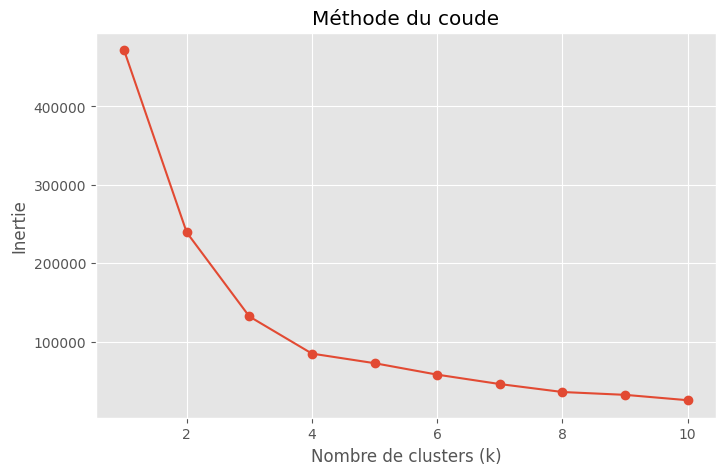

In [150]:
# Trouver le nombre optimal de clusters avec la méthode du coude
inertia = []
k_values = range(1, 11)  # Tester entre 1 et 10 clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=123)
    kmeans.fit(df_materials_scaled)
    inertia.append(kmeans.inertia_)

# Visualisation de la méthode du coude
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.title("Méthode du coude")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie")
plt.show()


In [151]:
# Appliquer K-Means avec un nombre choisi de clusters
optimal_k = 4  # Exemple, ajustez selon votre analyse du graphique
kmeans = KMeans(n_clusters=optimal_k, random_state=123)
df_materials_imputed["Cluster"] = kmeans.fit_predict(df_materials_scaled)

# Afficher les résultats
df_materials_imputed.head()


,Medium,Classification,Cluster
0,1148,1,3
1,1148,1,3
2,1148,1,3
3,1148,1,3
4,1148,1,3


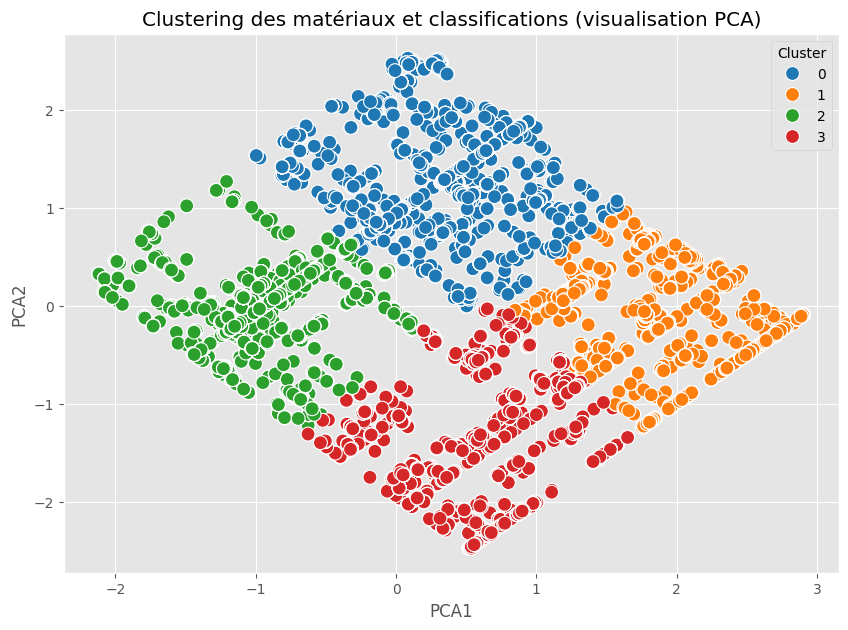

In [152]:
from sklearn.decomposition import PCA

# Réduction à 2 dimensions pour la visualisation
pca = PCA(n_components=2)
df_materials_pca = pca.fit_transform(df_materials_scaled)

# Ajouter les clusters pour la visualisation
df_materials_imputed["PCA1"] = df_materials_pca[:, 0]
df_materials_imputed["PCA2"] = df_materials_pca[:, 1]

# Visualisation
plt.figure(figsize=(10, 7))
sns.scatterplot(x="PCA1", y="PCA2", hue="Cluster", data=df_materials_imputed, palette="tab10", s=100)
plt.title("Clustering des matériaux et classifications (visualisation PCA)")
plt.show()


In [153]:
# Distribution des clusters
df_materials_imputed["Cluster"].value_counts()

# Sauvegarder les résultats
df_materials_imputed.to_csv("clustering_materials_results.csv", index=False)


In [154]:
# Ajouter la colonne des clusters au DataFrame original
# Assurez-vous que les index correspondent pour l'intégration
df["Cluster"] = np.nan  # Initialisation avec des NaN
df.loc[df_materials_imputed.index, "Cluster"] = df_materials_imputed["Cluster"]

# Vérification
df.head()

# Sauvegarder le DataFrame original avec les clusters ajoutés
df.to_csv("MetObjects_with_clusters.csv", index=False)

In [155]:
# Charger les données nécessaires
columns_to_use = [col for col in df.columns if col != "Is Highlight"]  # Exclure la cible
target = "Is Highlight"

# Supprimer les lignes avec trop de valeurs manquantes
df_filtered = df.dropna(subset=[target])  # Garder les lignes avec une cible définie

# Imputation pour les valeurs manquantes
imputer = SimpleImputer(strategy="constant", fill_value="Unknown")
df_imputed = pd.DataFrame(imputer.fit_transform(df_filtered), columns=df_filtered.columns)

# Encodage LabelEncoder pour les colonnes catégoriques
for col in df_imputed.select_dtypes(include="object").columns:
    df_imputed[col] = df_imputed[col].astype(str)  # Convertir toutes les valeurs en chaînes
    le = LabelEncoder()
    df_imputed[col] = le.fit_transform(df_imputed[col])


# Séparer les features et la cible
X = df_imputed[columns_to_use]
y = df_imputed[target]

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [156]:
# Gestion du déséquilibre des classes
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=123)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
# X_resampled 32 colonnes

In [157]:
# Entraînement du modèle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Diviser les données
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=123)
print("X_train colonnes : ")
print(X_train.shape)
print("X_test colonnes : ")
print(X_test.shape)

# Entraîner un modèle de forêt aléatoire
model = RandomForestClassifier(n_estimators=10, random_state=123, verbose=2)
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


X_train colonnes : 
(376150, 101)
X_test colonnes : 
(94038, 101)
building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     47049
           1       1.00      1.00      1.00     46989

    accuracy                           1.00     94038
   macro avg       1.00      1.00      1.00     94038
weighted avg       1.00      1.00      1.00     94038

Confusion Matrix:
 [[46923   126]
 [   40 46949]]


In [158]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
scores = cross_val_score(model, X_resampled, y_resampled, cv=skf)
print("Validation croisée stratifiée (5-fold):", scores)
print("Score moyen :", scores.mean())

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
buildi

In [159]:
print(len(columns_to_use))
print(len(model.feature_importances_))

101
101


In [160]:
# Récupérer les importances des features
importances = model.feature_importances_

# Créer un DataFrame pour organiser les résultats
feature_importance_df = pd.DataFrame({
    "Feature": columns_to_use,  # Correspond aux colonnes utilisées pour entraîner le modèle
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Afficher les 10 features les plus importantes
print(feature_importance_df.head(10))


             Feature  Importance
1   Is Timeline Work    0.184000
4         Department    0.129031
26    Classification    0.090745
6        Object Name    0.064806
24        Dimensions    0.057462
25       Credit Line    0.046883
5      AccessionYear    0.039497
23            Medium    0.039279
27     Link Resource    0.031504
3          Object ID    0.030210


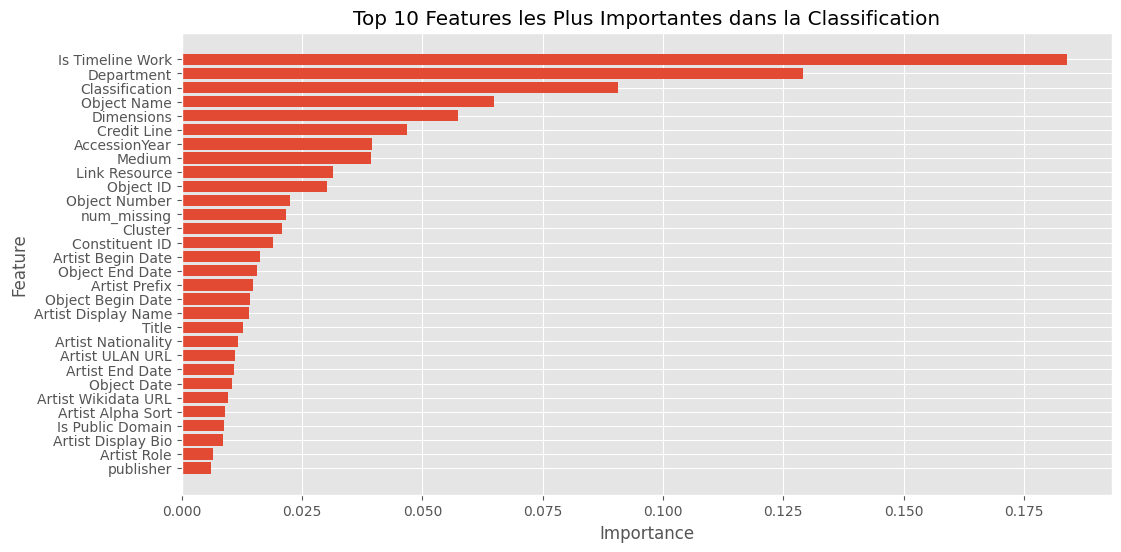

In [161]:
import matplotlib.pyplot as plt

# Trier les données par importance décroissante et sélectionner les 10 premières
top_features = feature_importance_df.nlargest(30, "Importance")

# Tracer un graphique des importances
plt.figure(figsize=(12, 6))
plt.barh(top_features["Feature"], top_features["Importance"], align='center')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Features les Plus Importantes dans la Classification")
plt.gca().invert_yaxis()  # Inverser l'axe pour afficher les features les plus importantes en haut
plt.show()


In [162]:
# Sauvegarder les prédictions
df_results = df_imputed.copy()
df_results["Is Highlight_Predicted"] = model.predict(scaler.transform(X))
df_results.to_csv("highlight_predictions.csv", index=False)